In [63]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sys 
sys.path.append('../Function/')
import function
from function import split_date

In [64]:
df = pd.read_excel('../../site_info_ver_3.3.xlsx')

#start 

In [182]:
dataset = df
dataset = dataset['Eilat Coral Beach' == dataset.Site_Name ]
# dataset = dataset[dataset.is_weekend==1]
# dataset = dataset.loc[dataset.year>2018]
dataset.shape
sites = dataset.Site_Name.unique()
print(sites,len(sites))

['Eilat Coral Beach'] 1


In [183]:
dataset.shape

(1903, 85)

In [184]:
dataset = split_date(dataset)

Split Data Successfully


In [185]:
dataset = pd.get_dummies(dataset)
dataset.head(1)

,Date,Israelis_Count,Tourists_Count,Total,region_Central,region_Judea_Samaria,region_North,region_South,is_weekend,operations,...,Beer-Sheva_nox_exceeded,Green_border,Season_autumn,Season_spring,Season_summer,Season_winter,day,month,year,Site_Name_Eilat Coral Beach
0,2016-01-01,35,52,87,0,0,0,1,1,0,...,0,0,0,0,0,1,1,1,2016,1


In [186]:
drop_one_unique = [x for x in dataset.columns if len(dataset[x].value_counts())==1]
drop_one_unique

['region_Central',
 'region_Judea_Samaria',
 'region_North',
 'region_South',
 'is_camping',
 'special_activity',
 'visit_duration',
 'is_jewishHeritage',
 'is_muslimsHeritage',
 'is_christiansHeritage',
 'is_nationalPark',
 'is_natureReserve',
 'is_archaeology',
 'is_religion',
 'is_animals',
 'is_heritage',
 'is_water',
 'is_cave',
 'is_lookout',
 'Tel_Aviv-Yafo_so2_exceeded',
 'Jerusalem_so2_exceeded',
 'Ashkelon_so2_exceeded',
 'Beer-Sheva_so2_exceeded',
 'Green_border',
 'Site_Name_Eilat Coral Beach']

In [187]:
pollutions = ['nox','pm10','pm2.5','so2']
print(dataset[pollutions].isna().sum())
# dataset.dropna(inplace=True,axis=1)
dataset.drop(pollutions,axis=1,inplace=True)

nox         0
pm10        0
pm2.5    1058
so2         0
dtype: int64


In [188]:
dataset.drop(drop_one_unique,axis=1,inplace=True)

corr = function.remove_high_corr(dataset.drop(['Temperature','Tourists_Count','Total'],axis=1), 'Israelis_Count', 0.4)
print(corr)
dataset.drop(corr,axis=1,inplace=True)
dataset.set_index("Date",inplace=True)


['Jerusalem_pm10_exceeded', 'Tel_Aviv-Yafo_pm2.5', 'is_Site_exceeded_pm2.5', 'Jerusalem_pm10', 'Tel_Aviv-Yafo_pm2.5_exceeded', 'Beer-Sheva_pm2.5_exceeded', 'Tel_Aviv-Yafo_nox', 'is_muslims_vacation', 'Ashkelon_pm10_exceeded', 'Haifa_nox', 'is_HeatWave', 'Ashkelon_pm10', 'Ashkelon_nox', 'Jerusalem_pm2.5_exceeded', 'Haifa_pm10', 'is_Site_exceeded_pm10', 'Haifa_so2', 'Beer-Sheva_nox_exceeded', 'Season_autumn', 'Season_spring', 'Jerusalem_pm2.5', 'Ashkelon_pm2.5', 'Tel_Aviv-Yafo_pm10_exceeded', 'Ashkelon_nox_exceeded', 'Tel_Aviv-Yafo_pm10', 'is_jewish_vacation', 'Tel_Aviv-Yafo_so2']


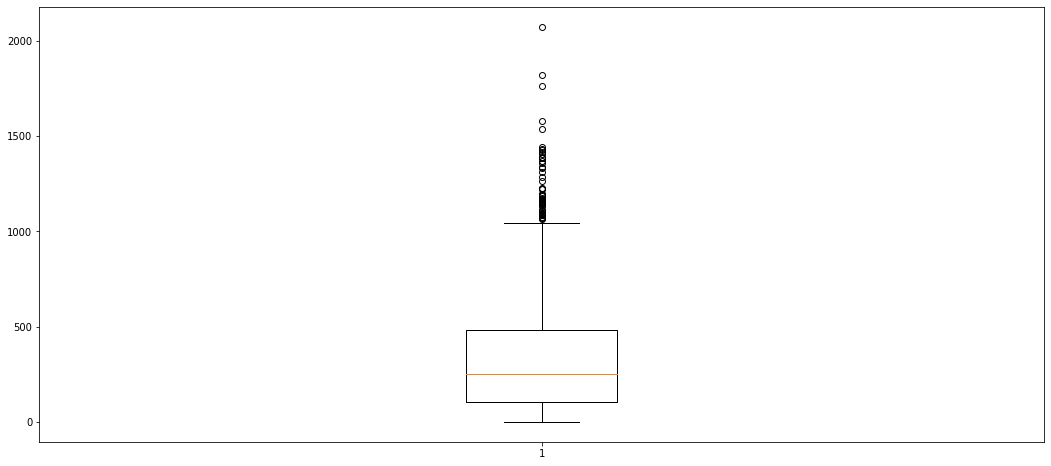

In [189]:
dataset = function.remove_outliers(dataset, 'Israelis_Count')

In [190]:
dataset.isna().sum()

Israelis_Count                0
Tourists_Count                0
Total                         0
is_weekend                    0
operations                    0
is_jewish_holiday             0
is_muslims_holiday            0
Temperature                   0
Beer-Sheva_pm10               0
Haifa_pm2.5                   0
Beer-Sheva_pm2.5              0
Jerusalem_nox                 0
Beer-Sheva_nox                0
Jerusalem_so2                 0
Ashkelon_so2                  0
Beer-Sheva_so2                0
is_Site_exceeded_nox          0
is_Site_exceeded_so2          0
Haifa_pm10_exceeded           0
Beer-Sheva_pm10_exceeded      0
Haifa_pm2.5_exceeded          0
Ashkelon_pm2.5_exceeded       0
Haifa_so2_exceeded            0
Tel_Aviv-Yafo_nox_exceeded    0
Jerusalem_nox_exceeded        0
Haifa_nox_exceeded            0
Season_summer                 0
Season_winter                 0
day                           0
month                         0
year                          0
dtype: i

In [191]:
target_str = 'Israelis_Count'
X = dataset.drop(['Israelis_Count','Tourists_Count','Total'],axis=1)
# X = dataset[['Temperature']]
y = dataset.Israelis_Count


X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=0.2)

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import Normalizer 
train_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()
train_target_scaler = Normalizer()
test_target_scaler = Normalizer()

X_train_scaled = train_scaler.fit_transform(X_train)
y_train_scaled = np.log([y_train.values+0.01]).T
X_test_scaled = test_scaler.fit_transform(X_test)
y_test_scaled = np.log([y_test.values+0.01]).T
y_train_scaled.shape


(1476, 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


322.78177438563716
251.18013472476403


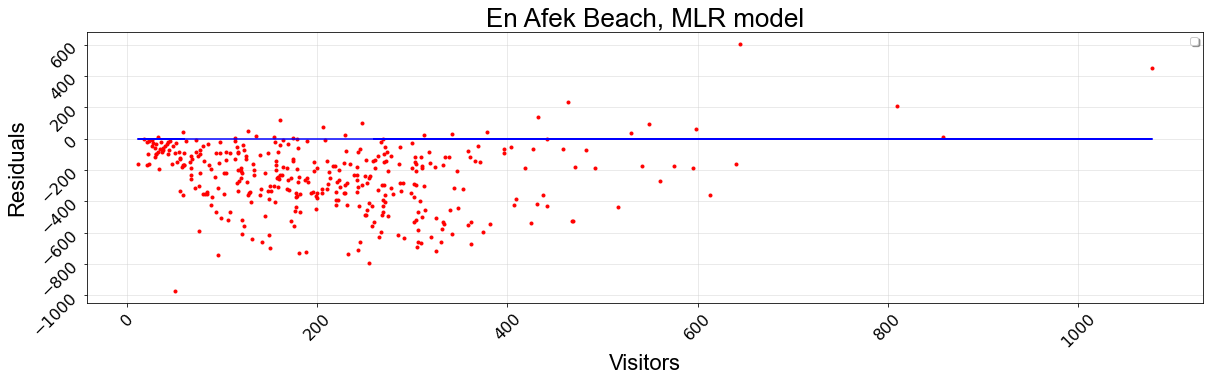

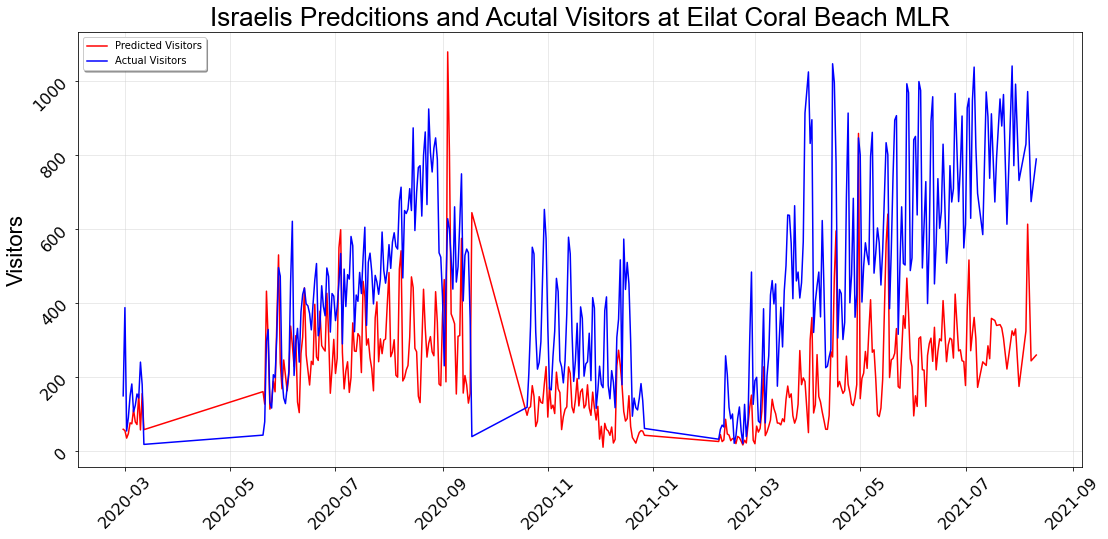

In [195]:
mlr = LinearRegression()
mlr.fit(X_train_scaled, y_train_scaled)

predicion_scaled = mlr.predict(X_test_scaled)
predicion = np.exp(predicion_scaled.T).T

predicion=predicion.reshape(predicion.shape[0])
res = pd.DataFrame(data={
    'Prediction':predicion,
    "Actual":y_test.values
}, index=y_test.index)
res =res.sort_index()

rmse = function.get_rmse(res['Prediction'], res['Actual'])
print(rmse)
std = np.std(res['Actual'])
print(std)
function.plot_residuals(
    predicion=res.Prediction,
    actual= res.Actual,
    title='En Afek Beach, MLR model',
    fig_size_tuple=(20,5))
# function.plot_residuals(res.Prediction, res.Actual,title='North Sites, MLR model, Weekend',fig_size_tuple=(20,5),ylim=(-1000,1000),xlim=(0,1000))
function.plot_line(
    predicion=res.Prediction,
    actual= res.Actual,
    title='Israelis Predcitions and Acutal Visitors at Eilat Coral Beach MLR')


In [193]:
coef = sorted( list(zip(mlr.coef_.T,X_train.columns)))
coef

[(array([-2.37874754]), 'Beer-Sheva_pm2.5'),
 (array([-0.64413473]), 'Season_winter'),
 (array([-0.32008707]), 'Tel_Aviv-Yafo_nox_exceeded'),
 (array([-0.1737474]), 'Beer-Sheva_pm10_exceeded'),
 (array([-0.16025093]), 'Haifa_pm2.5_exceeded'),
 (array([-0.16013923]), 'operations'),
 (array([-0.14516062]), 'Haifa_pm10_exceeded'),
 (array([-0.11629067]), 'is_muslims_holiday'),
 (array([-0.10734575]), 'Jerusalem_nox_exceeded'),
 (array([-0.07637839]), 'Haifa_so2_exceeded'),
 (array([-0.00255605]), 'Ashkelon_so2'),
 (array([0.0061229]), 'is_Site_exceeded_nox'),
 (array([0.02560704]), 'Season_summer'),
 (array([0.0259825]), 'Ashkelon_pm2.5_exceeded'),
 (array([0.0478203]), 'Beer-Sheva_so2'),
 (array([0.08837206]), 'Jerusalem_nox'),
 (array([0.14578141]), 'day'),
 (array([0.20239783]), 'year'),
 (array([0.20557567]), 'Jerusalem_so2'),
 (array([0.26590453]), 'is_Site_exceeded_so2'),
 (array([0.31484358]), 'Haifa_nox_exceeded'),
 (array([0.31682475]), 'Beer-Sheva_nox'),
 (array([0.49034242]), '